# AJ Data Pre-Processing

In [3]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import csv
import json
import numpy as np
import tcxparser
import glob
import time
import statistics
import numpy

#### Relevant Parameters of interest (user specific)

In [2]:
paths_to_data = {'fit':'./Data/Juan/Run/Fit', 'arduino':'./data/arduino/Run'}
data_dir = os.getcwd()+'/Data/Juan/Run/'

path_to_tcx = 'Actividades/*_Correr.tcx'

file_names = sorted(glob.iglob(os.path.join(paths_to_data['fit'], path_to_tcx)))


NameError: name 'os' is not defined

In [5]:
def missing_data_treatment(data, method='interpolation'):
    """
    We see that the arduino app generates a lot of missing data points. We will implement a few different approaches to 
    deal with this missing data:
    :param method: (str) The methods we will implement are:
        - 'constant': Will adopt the value of the previous observation
        - 'interpolation': Interpolate the data since we are in a continuous domain
        - 'nearest': Adopts the value of the nearest value
    """
    df = data.copy()
    if method == 'interpolation':
        df.interpolate(method='linear', inplace=True)
    elif method == 'constant':
        df.interpolate(method='zero', inplace=True)
    elif method == 'nearest':
        df.interpolate(method='nearest', inplace=True)
    else:
        raise ValueError('The method specified is not defined. Please review function missing_data_treeatment')
    return df

In [6]:
def session_start(data, method='inference', value=None):
    """
    Sessions don't start in the moment in which Arduino starts recording data. There are a few residual seconds before
    we actually start running (e.g. setting up device). 
    We will implement 3 different methods:
    :param method: (str) 
        - 'inference': Look at the data and try to guess when we are actually starting to run. The idea until now is:
                - Look at the X, Y and Z axis for each user and see the most regular one (depends on how the device is placed).
                - Based on the best feature, estimate the average amplitude of a step (Avarage amplitude is calculated for each interval of n measurements)
                - Start is defined as the starting point of the first interval wich passes the avg threshold.
                - End is defined as the starting point of the first interval (from the end of the time series) wich passes the avg threshold.
                - Set the timer at the stage in which the amplitude is below a certain threshold
        - 'percentage': Remove the initial 2% of the observations (try to be conservative, better to remove part of the session
                        than keep irrelevant data)
        - 'fixed': Set a fixed starting point (not recommended but  can be usefull for testing purposes)
    :param value: (depends) If the method is  inference leave the default value, if the method is percentage provide float 
                  between 0 and 1 (e.g. 0.02 to remove  2% of the initial data set), if the method is fixed provide a string 
                  with date format (e.g. '2021-05-02 18:01:00')
    """
    
    df = data.copy().dropna()
    if method == 'inference':
        
        n = 100 # n=100 seemed like a good compromise to me in order to avoid detecting local changes.
        Y = [abs(x) for x in df.AccY.tolist()]
        ampl = [statistics.mean(Y[x:x+n]) for x in range(1,(len(Y)//n)*n,n)]
        start = np.where(np.array(ampl) > statistics.mean(ampl))[0][0]*n
        end = np.where(np.array(ampl[::-1]) > statistics.mean(ampl))[0][0]*n
        start_timestamp = df.iloc[[start]].index[0]
        end_timestamp = df.iloc[[len(Y)-end-1]].index[0]
        print('Number of observations excluded with inference method:', start+end)
        
        ########################## to be deleted, just for check
        plt.figure(figsize=(20,8))
        plt.plot(df.AccY.tolist(),color='#F7EBE8')
        plt.axvline(x=start, color='g', linestyle='--')
        plt.axvline(x=len(Y)-end, color='r', linestyle='--')
        plt.show()
        #######################################################
        
        df = df[df.index > start_timestamp]
        df = df[df.index < end_timestamp]
        
    elif method == 'percentage':
        length = len(data)*value
        df = df[int(length):]
    elif method == 'fixed':
        df = df[df > value]
    else:
        raise ValueError('The method specified is not defined. Please review function session_start')
    
    return df

In [1]:
def generate_full_time_series_AJ(path, file_identifier='Run_', plot=None, google_files=file_names, period=1):
    
    """
    We have decided to generate a full time series as dataset (i.e. put all the sessions together, making several 
    time series into a single one). For this purpose we will simply do individual pre-processing steps on each 
    of the csv files and then merge everything together
    :param path: (str) Folder in which csv files can be found
    :param file_identifier: (str) Identifier of each csv file
    """
    session_files =  [i for i in os.listdir(path) if re.search(file_identifier, i)] 
    full_df = pd.DataFrame()
    
    google_df = load_tcx(google_files)
    
    for session in session_files:
                
        df = pd.read_csv(path + session)
        df['timestamp'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df_missing = missing_data_treatment(df, method='interpolation')
        df_start = session_start(df_missing, method='inference',value=None)
        print(re.findall('\d+', session)[0])
        print('Session Start: ' + str(min(df_start.index)))
        print('Session End: ' + str(max(df_start.index)))
        reduce_tcx_df = google_df[(google_df.timestamp > str(min(df_start.index))) & 
                                  (google_df.timestamp < str(max(df_start.index)))].set_index('timestamp')
        
        #return reduce_tcx_df, df_start
        # Intermediate step to remove google data duplicates for distance and altitude seperately
        reduce_tcx_df.reset_index(level=0, inplace=True)
        dist_df = reduce_tcx_df.groupby('distance').last().reset_index(level=0).set_index('timestamp')
        alt_df = reduce_tcx_df.groupby('altitude').last().reset_index(level=0).set_index('timestamp')
        
        merged = df_start.merge(dist_df[['distance', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['distance'] = merged['distance'].interpolate(method='index')
        
        merged = merged.merge(alt_df[['altitude', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['altitude'] = merged['altitude'].interpolate(method='index')
        
        
        df_final = merged[~(merged.google_fit_x == True) | ~(merged.google_fit_y == True)]
        #df_final.dropna(subset=['altitude', 'distance'], inplace=True)
        df_final.drop(columns=['google_fit_x', 'google_fit_y'], inplace=True)
        df_final = df_final[(df_final.index > str(min(df_start.index))) & 
                             (df_final.index < str(max(df_start.index)))]
        
        # Add pace to as feature
        df_final['delta_distance']= df_final.distance.diff(periods=period)
        df_final['delta_time'] = [0]*period+[(df_final.index[i]-df_final.index[i-period]).total_seconds() 
                                                for i in range(period,df_final.shape[0])]
        df_final = df_final[period:]
        df_final['pace']=(df_final.delta_distance/1000)/(df_final.delta_time/3600)
        
        print('+++++++++++++++')
        full_df = pd.concat([full_df, df_final])        
        
        
    print('Finished pre-processing individual time series')
    full_df.sort_values(by='timestamp', inplace=True)
    
    if plot:
        plt.figure(figsize=(20, 12))
        plt.plot(full_df[plot])
        plt.show()
     
    
    return full_df
    

NameError: name 'file_names' is not defined

In [8]:
def load_tcx(file_list):
   
    """
    Load tcx files into pandas DataFrame
    
    Known issue: 
    the lists altitude, timestamp and distance have not the same length;
    we don't know the position of the missing data (potential values' shift);
    """
    df = pd.DataFrame(columns=['timestamp','altitude',
                               'distance', 
                               'google_fit'])
    
    for file in file_list:
        tcx_obj = tcxparser.TCXParser(file)
        #print(tcx_obj.time_values()[0])
        #print(tcx_obj.time_values()[-1])
        default_len = min([len(tcx_obj.time_values())],
                          [len(tcx_obj.altitude_points())],
                          [len(tcx_obj.distance_values())])[0]
        data_dict = {'timestamp':tcx_obj.time_values()[-default_len:], 
                     'altitude':tcx_obj.altitude_points()[-default_len:], 
                     'distance':tcx_obj.distance_values()[-default_len:],
                     'google_fit': [True] * default_len}
        tmp_df = pd.DataFrame.from_dict(data_dict)
        df = pd.concat([df, tmp_df], ignore_index=True)
        print('======================')
        
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
    hours_added = timedelta(hours = 2)
    df['timestamp'] = df['timestamp'] + hours_added
    df['distance'] = pd.to_numeric(df.distance.astype(str))
        
    return df.sort_values(by='timestamp')

Number of observations excluded with inference method: 4400


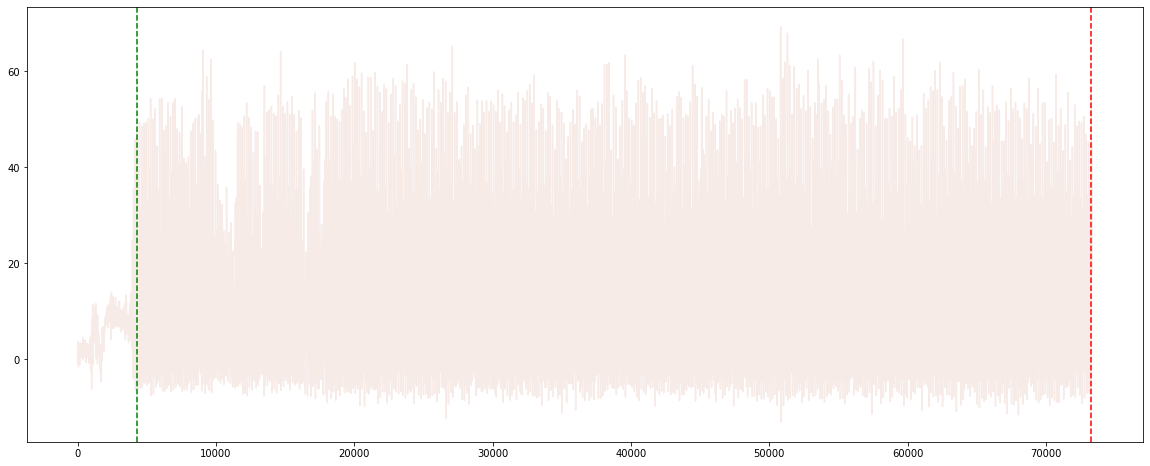

3004
Session Start: 2021-04-30 19:01:58.098000
Session End: 2021-04-30 19:07:10.619000
+++++++++++++++
Number of observations excluded with inference method: 2900


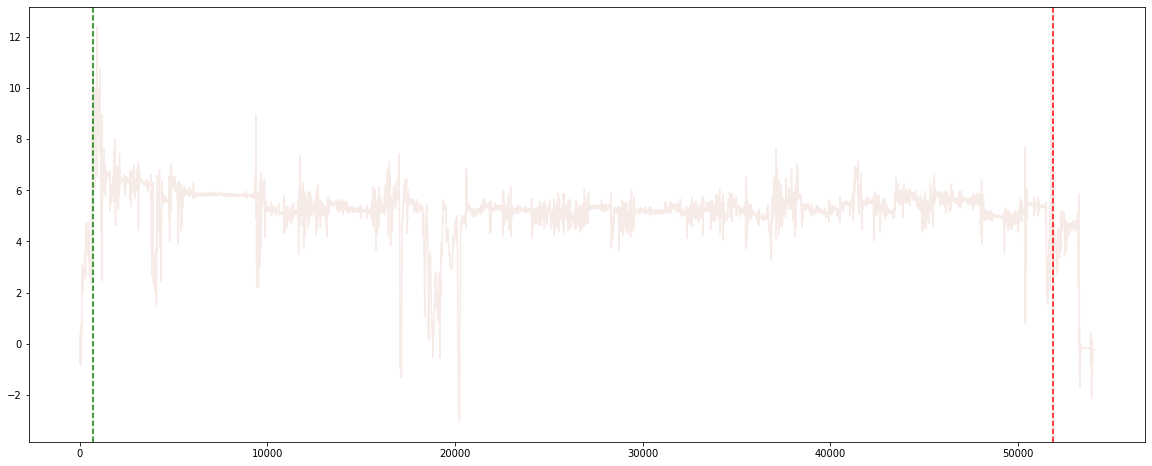

9999
Session Start: 2021-05-09 17:42:23.313000
Session End: 2021-05-09 17:52:29.167000
+++++++++++++++
Number of observations excluded with inference method: 2500


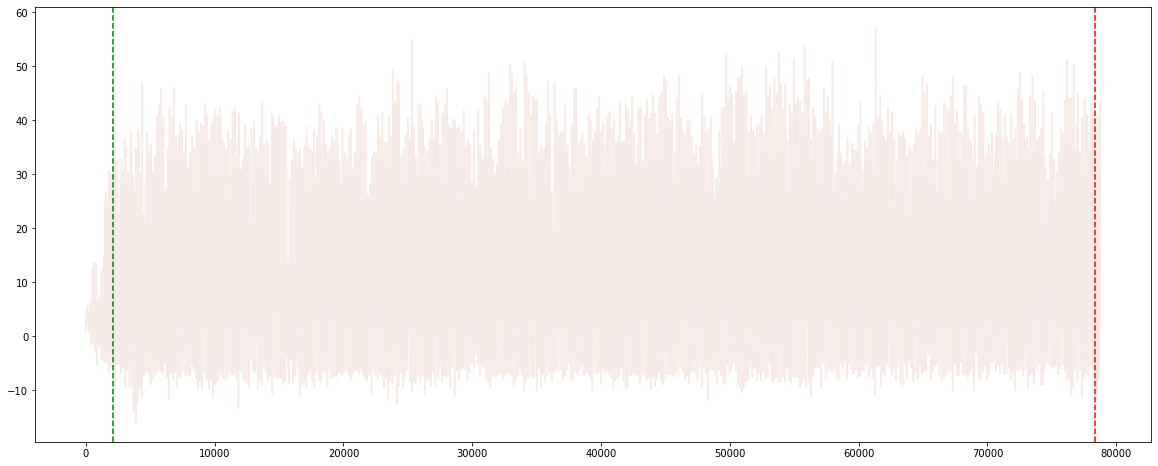

2204
Session Start: 2021-04-22 19:14:35.703000
Session End: 2021-04-22 19:20:16.057000
+++++++++++++++
Number of observations excluded with inference method: 2000


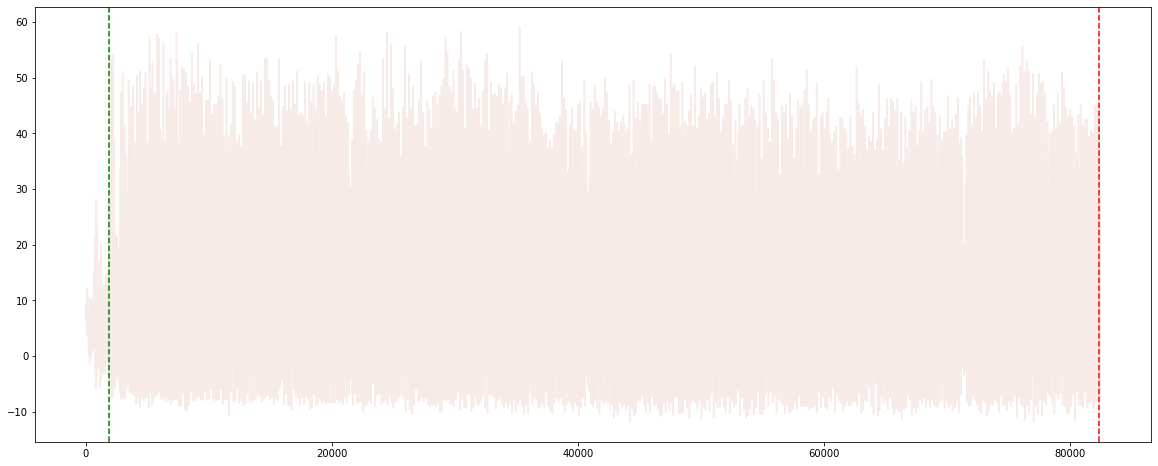

2204
Session Start: 2021-04-24 19:17:59.281000
Session End: 2021-04-24 19:24:34.615000
+++++++++++++++
Number of observations excluded with inference method: 12100


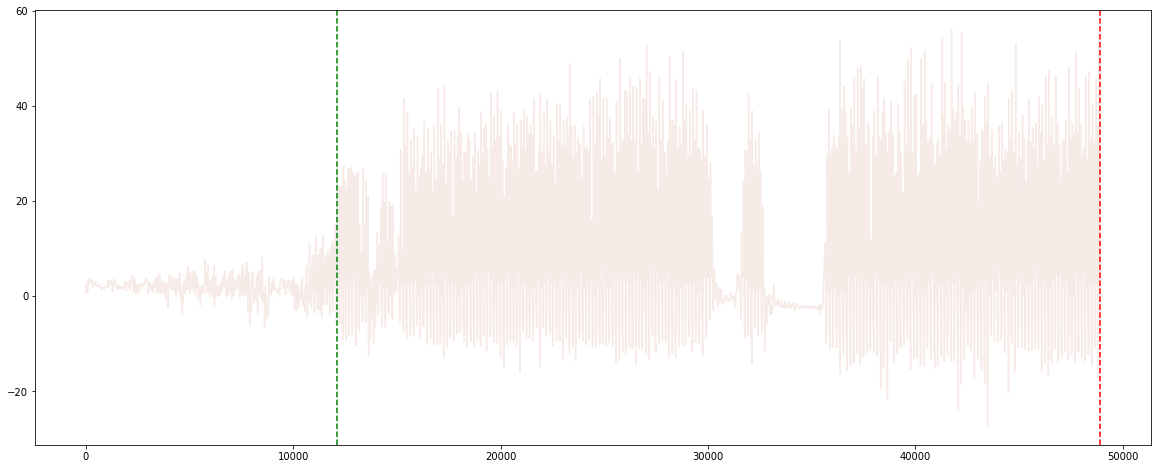

1304
Session Start: 2021-04-13 18:51:32.530000
Session End: 2021-04-13 18:54:21.900000
+++++++++++++++
Number of observations excluded with inference method: 3600


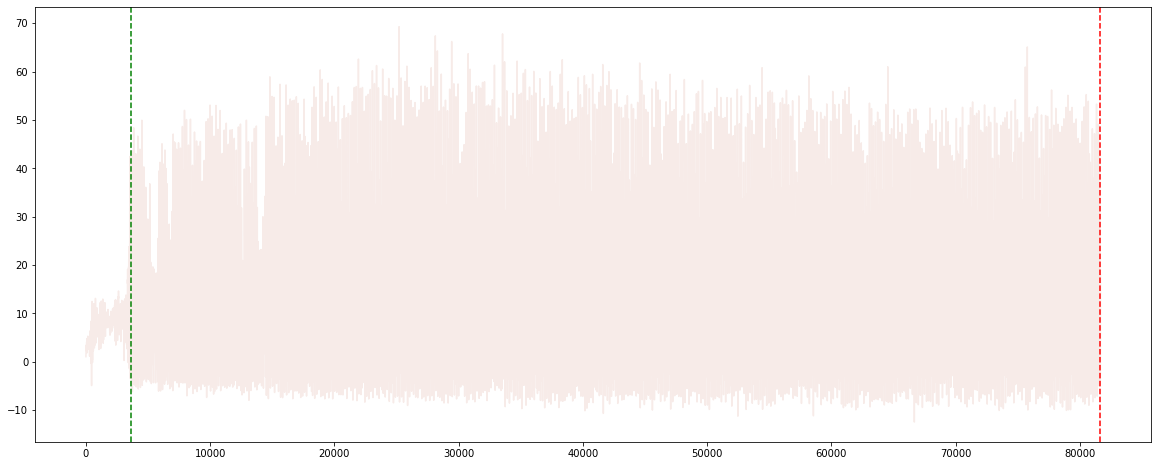

0205
Session Start: 2021-05-02 18:00:25.444000
Session End: 2021-05-02 18:06:20.425000
+++++++++++++++
Number of observations excluded with inference method: 9600


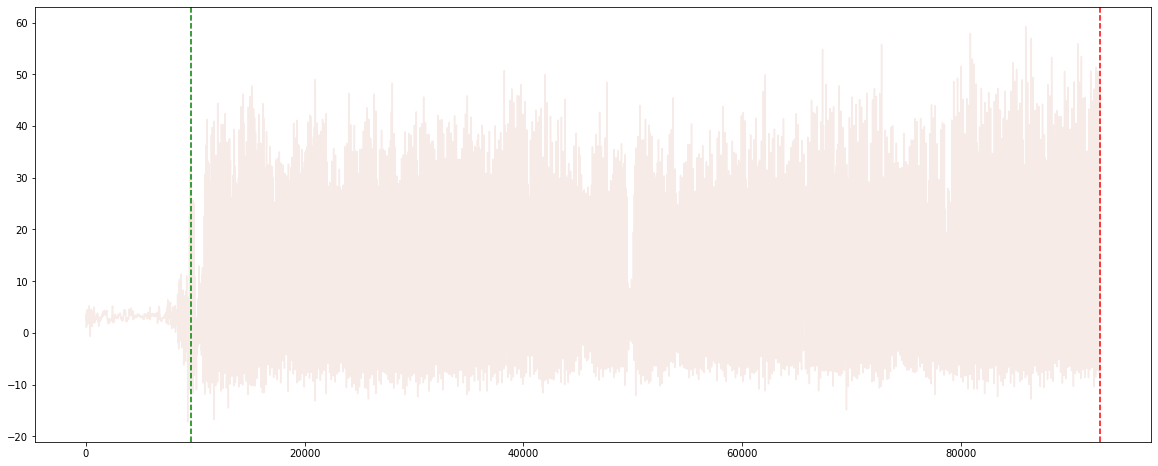

1504
Session Start: 2021-04-15 17:25:58.756000
Session End: 2021-04-15 17:32:12.595000
+++++++++++++++
Number of observations excluded with inference method: 3200


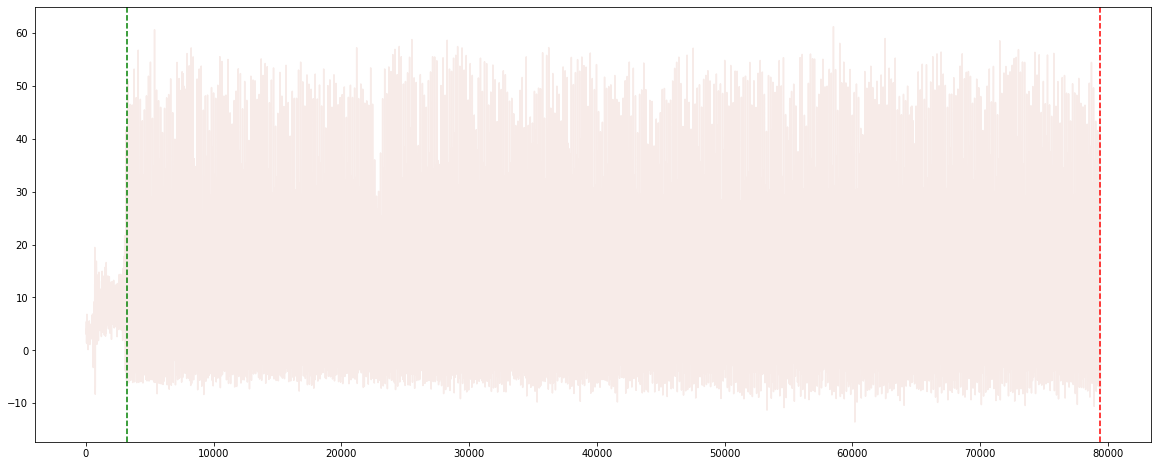

0405
Session Start: 2021-05-04 18:58:46.296000
Session End: 2021-05-04 19:04:34.157000
+++++++++++++++
Number of observations excluded with inference method: 4500


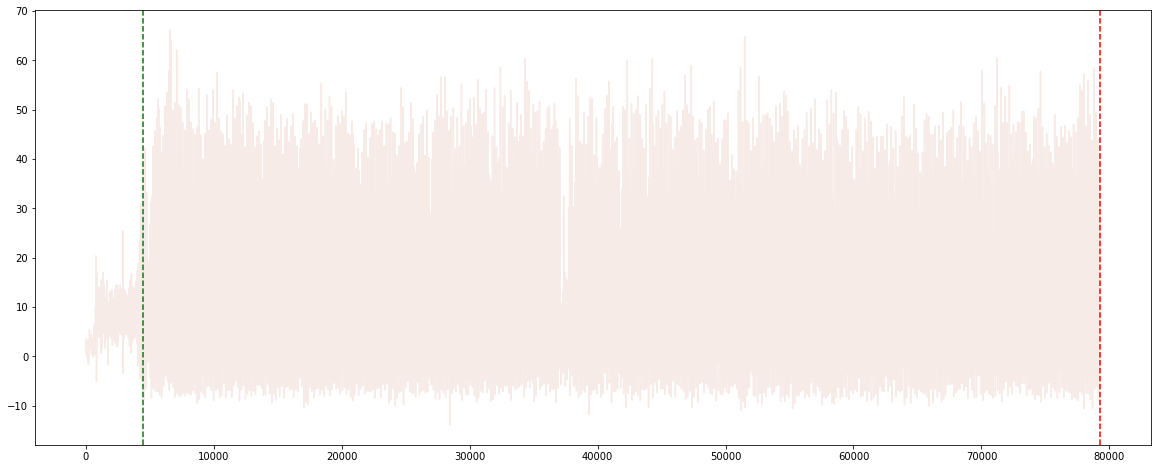

0905
Session Start: 2021-05-09 19:05:12.255000
Session End: 2021-05-09 19:10:57.755000
+++++++++++++++
Number of observations excluded with inference method: 10000


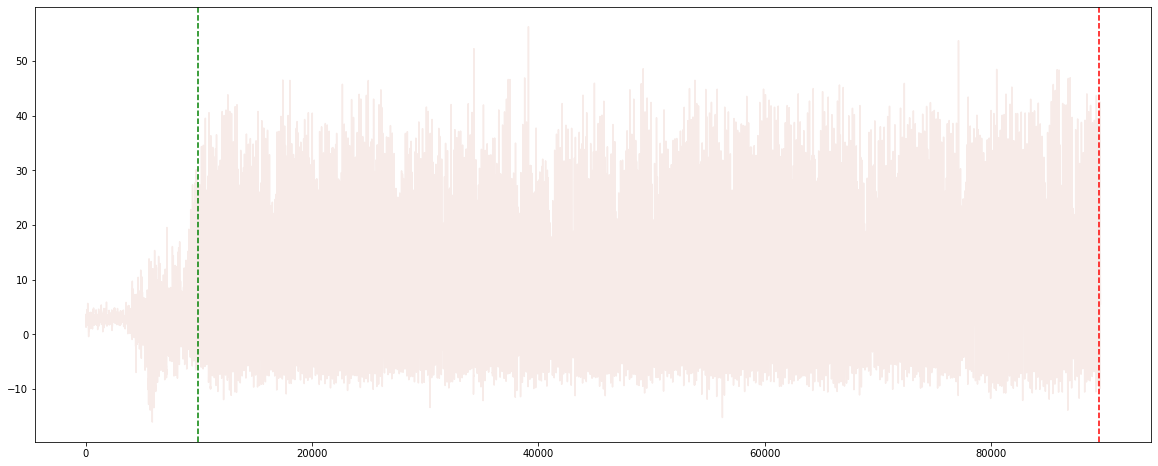

1604
Session Start: 2021-04-16 19:17:51.217000
Session End: 2021-04-16 19:23:54.212000
+++++++++++++++
Number of observations excluded with inference method: 1000


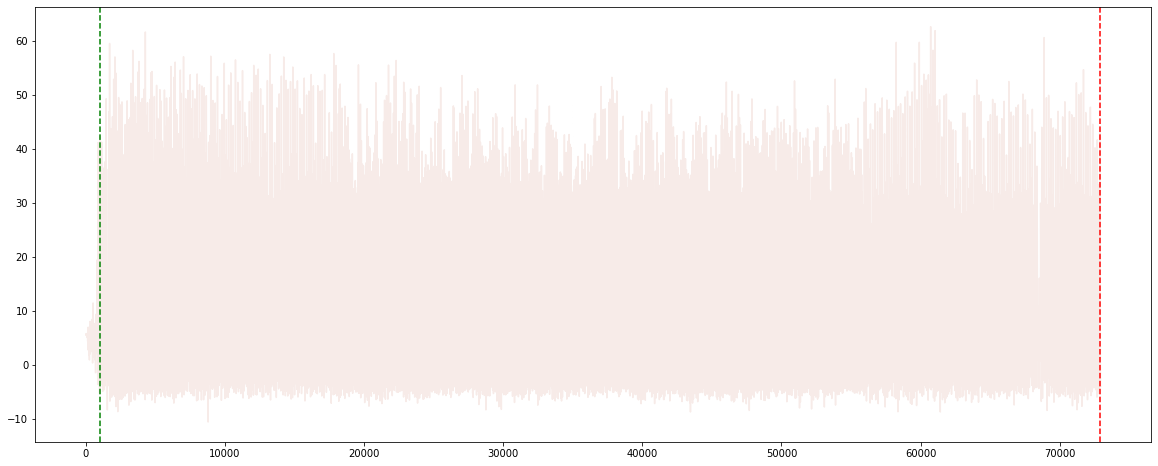

2704
Session Start: 2021-04-27 18:49:01.882000
Session End: 2021-04-27 18:58:58.329000
+++++++++++++++
Number of observations excluded with inference method: 2600


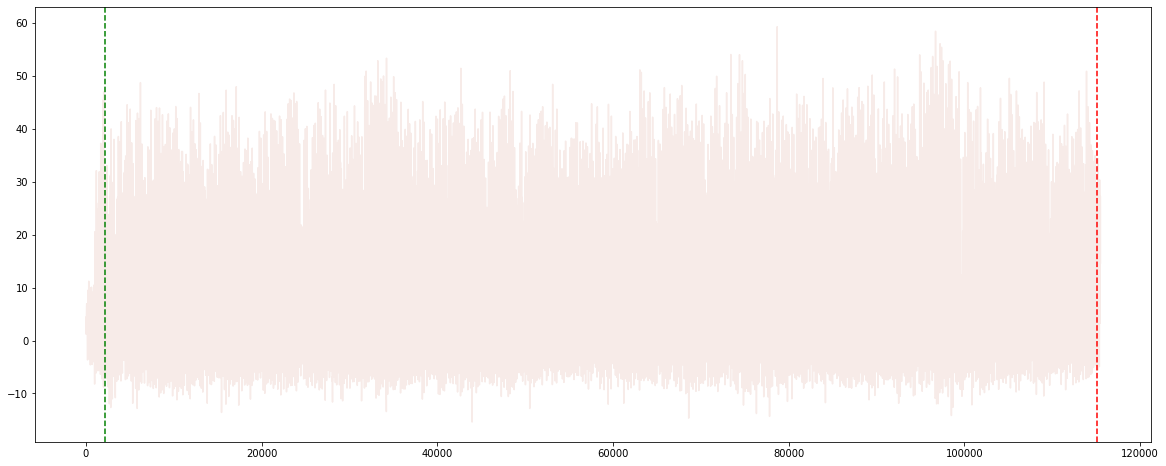

2104
Session Start: 2021-04-21 19:00:43.149000
Session End: 2021-04-21 19:09:07.946000
+++++++++++++++
Finished pre-processing individual time series


In [187]:
full = generate_full_time_series_AJ('Data/Juan/Run/')

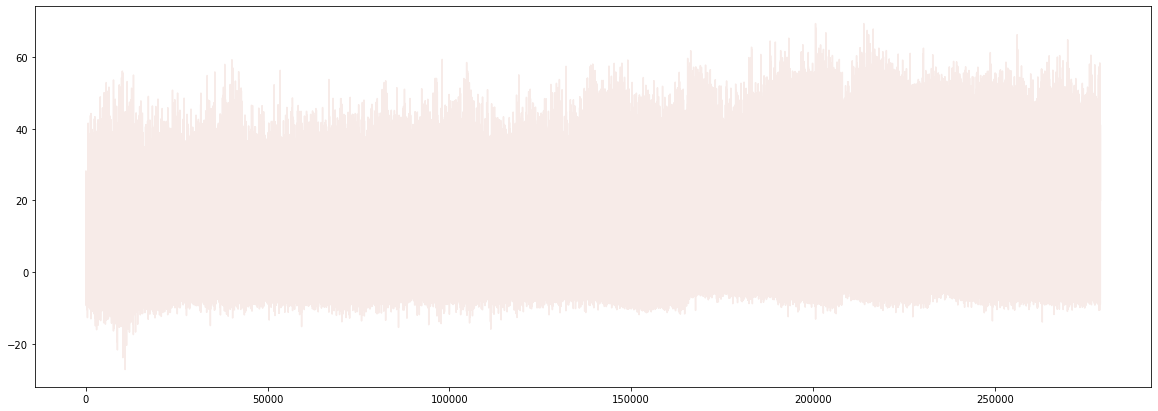

In [204]:
full = full[(full.AccY>20) | (full.AccY < -5)]
Y=full.AccY.tolist()
plt.figure(figsize=(20,7))
plt.plot(Y,color='#F7EBE8')

# Feature engineering 


### Predicted fatures (pace)

Calculate deltas for:

    - Altitude
    - Distance
    - Timestamp

Calculate the pace by dividing $\frac{\Delta distance}{\Delta time}$

Problem: repetitive values which would lad to delta = 0 so pace = 0

Possible strategies:
1. Distance interpolation instead of repetitive values?
2. Remove duplicates and keep first

### Predicting Features

Keep some features ad they are since they are significant in values not in how they change:

    - Decibel Source 
    - Linear Accelerometer Sensor
    - AccX
    - AccY
    - AccZ
    - Distance
    - Timestamp
 
Some others are kept as they are:

    - Altitude

In [450]:
## test dataset
df=pd.read_csv('Data/preprocessed_run_9.csv')
df

,timestamp,DecibelSource,LinearAccelerometerSensor,AccX,AccY,AccZ,altitude,distance
0,2021-05-02 19:18:40.882,72.361422,12.995637,1.812592,3.614197,-3.643494,70.890676,50.597658
1,2021-05-02 19:18:40.891,74.438284,13.730925,4.076202,2.755173,-4.859039,70.890706,50.597658
2,2021-05-02 19:18:40.899,76.515147,13.580708,4.925652,2.316093,-5.535011,70.890735,50.597658
3,2021-05-02 19:18:40.901,75.605591,13.430490,5.775101,1.877014,-6.210983,70.890764,50.597658
4,2021-05-02 19:18:40.911,74.696035,13.280273,5.846893,0.924667,-6.139206,70.890794,50.597658
...,...,...,...,...,...,...,...,...
313580,2021-05-02 19:51:50.121,38.579179,5.704597,-0.957100,1.717489,-15.612381,70.325583,6131.374049
313581,2021-05-02 19:51:50.131,38.355182,6.486388,-3.973251,3.462657,-17.092346,70.326152,6131.374049
313582,2021-05-02 19:51:50.132,38.131184,7.268179,-8.079338,5.207825,-18.572311,70.326720,6131.374049
313583,2021-05-02 19:51:50.142,37.907187,8.049971,-12.185425,-2.336746,-2.590637,70.327289,6131.374049


In [456]:
# remove duplicates strategy
df = df.drop_duplicates('distance')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

<ipython-input-456-6d271d8a5451>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


,timestamp,DecibelSource,LinearAccelerometerSensor,AccX,AccY,AccZ,altitude,distance,delta_distance,delta_altitude,delta_time,pace
1,2021-05-02 19:18:40.891,74.438284,13.730925,4.076202,2.755173,-4.859039,70.890706,50.597658,0.000000,0.000029,0.009,0.000000
2972,2021-05-02 19:18:59.421,59.203907,13.028916,16.861053,-34.371857,7.698486,71.022407,50.755225,0.157566,-0.000046,0.009,17.507375
2973,2021-05-02 19:18:59.430,58.476046,13.966480,7.426147,-30.028885,7.971275,71.022361,50.912791,0.157566,-0.000046,0.009,17.507375
2974,2021-05-02 19:18:59.431,57.748186,14.904045,5.510295,-25.685913,8.244064,71.022314,51.070358,0.157566,-0.000046,0.001,157.566374
2975,2021-05-02 19:18:59.440,57.020325,15.841609,3.594442,-22.241447,8.078957,71.022268,51.227924,0.157566,-0.000046,0.009,17.507375
...,...,...,...,...,...,...,...,...,...,...,...,...
310502,2021-05-02 19:51:30.461,58.276271,8.130302,-2.365280,-0.970444,-0.142792,70.565322,6128.867708,0.626585,-0.000084,0.010,62.658521
310503,2021-05-02 19:51:30.471,60.391835,8.244889,-1.712036,-0.592377,-1.200409,70.565239,6129.494293,0.626585,-0.000084,0.010,62.658521
310504,2021-05-02 19:51:30.481,62.507399,8.359476,-1.968063,-1.121201,-3.274994,70.565155,6130.120878,0.626585,-0.000084,0.010,62.658521
310505,2021-05-02 19:51:30.487,64.622963,10.504909,-1.893890,-2.103455,-3.150566,70.565071,6130.747463,0.626585,-0.000084,0.006,104.430868


In [457]:
df['delta_distance']= df.distance.diff()
df['delta_altitude'] = df.altitude.diff()
df['delta_time'] = [0]+[(df.timestamp.iloc[i]-df.timestamp.iloc[i-1]).total_seconds() for i in range(1,df.shape[0])]
df = df[1:]
df['pace']=df.delta_distance/df.delta_time

<ipython-input-457-51e515a30642>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_distance']= df.distance.diff()
<ipython-input-457-51e515a30642>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_altitude'] = df.altitude.diff()
<ipython-input-457-51e515a30642>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

(array([7.305e+03, 7.210e+02, 5.590e+02, 7.690e+02, 6.900e+01, 8.400e+01,
        2.600e+01, 3.900e+01, 1.300e+01, 5.000e+00]),
 array([4.95991622e-03, 2.21899491e+02, 4.43794022e+02, 6.65688553e+02,
        8.87583085e+02, 1.10947762e+03, 1.33137215e+03, 1.55326668e+03,
        1.77516121e+03, 1.99705574e+03, 2.21895027e+03]),
 <a list of 10 Patch objects>)

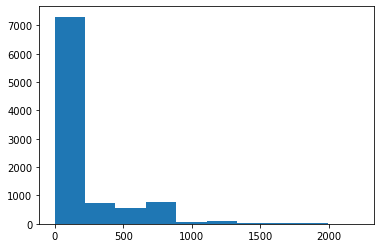

In [458]:
plt.hist(df.pace)

## Check correlation

In [367]:
#df = df.drop('delta_time',axis='columns')
#df = df.drop('delta_distance',axis='columns')

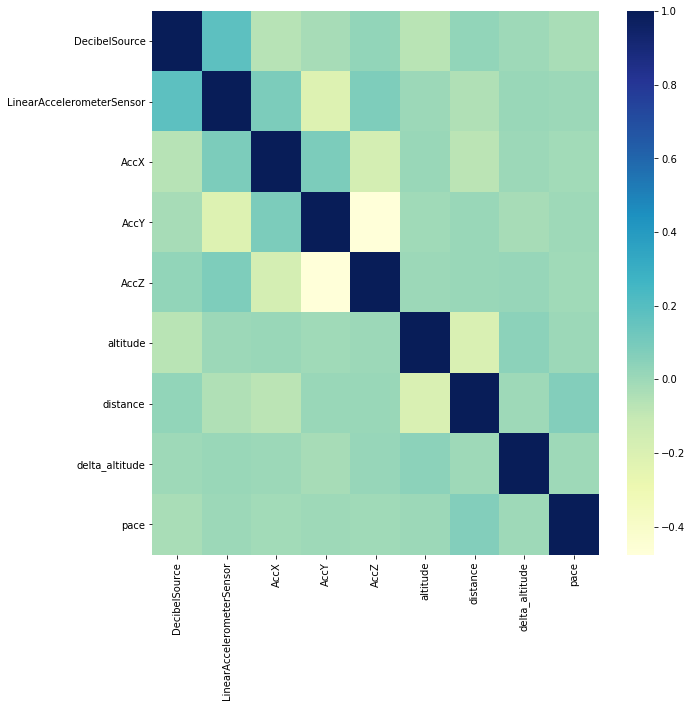

In [371]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap="YlGnBu")

In [294]:
df.cov(min_periods=100)

,DecibelSource,LinearAccelerometerSensor,AccX,AccY,AccZ,altitude,distance,delta_distance,delta_time,delta_altitude,pace
DecibelSource,69.889136,6.861250,-3.830108,-2.468282,2.132111,-2.191733,5.039943e+02,-0.171662,0.554530,-0.005572,-70.012258
LinearAccelerometerSensor,6.861250,21.366890,2.803408,-13.215383,3.260281,0.081190,-4.506902e+02,0.003211,0.096393,0.018404,6.101753
AccX,-3.830108,2.803408,48.223289,8.017078,-10.326460,0.297675,-1.045407e+03,-0.073614,-1.043800,0.012909,-26.631595
AccY,-2.468282,-13.215383,8.017078,174.858587,-56.485418,-0.195911,3.073905e+02,-0.039593,-3.679584,-0.101547,-0.280121
AccZ,2.132111,3.260281,-10.326460,-56.485418,80.521159,0.199224,1.815461e+02,0.014161,0.734978,0.052298,-11.923824
altitude,-2.191733,0.081190,0.297675,-0.195911,0.199224,13.348140,-1.389622e+03,-0.022221,-0.021961,0.050150,4.290089
distance,503.994311,-450.690203,-1045.406761,307.390521,181.546127,-1389.622361,3.911653e+06,144.752967,55.763811,-0.022352,37946.541757
delta_distance,-0.171662,0.003211,-0.073614,-0.039593,0.014161,-0.022221,1.447530e+02,0.131477,0.043266,-0.000710,41.907684
delta_time,0.554530,0.096393,-1.043800,-3.679584,0.734978,-0.021961,5.576381e+01,0.043266,5.727148,-0.011144,-43.355703
delta_altitude,-0.005572,0.018404,0.012909,-0.101547,0.052298,0.050150,-2.235242e-02,-0.000710,-0.011144,0.100296,0.099935


## Check Stationarity
The mean of the series should not be a function of time.
 
#### Rolling Statistics
Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time.

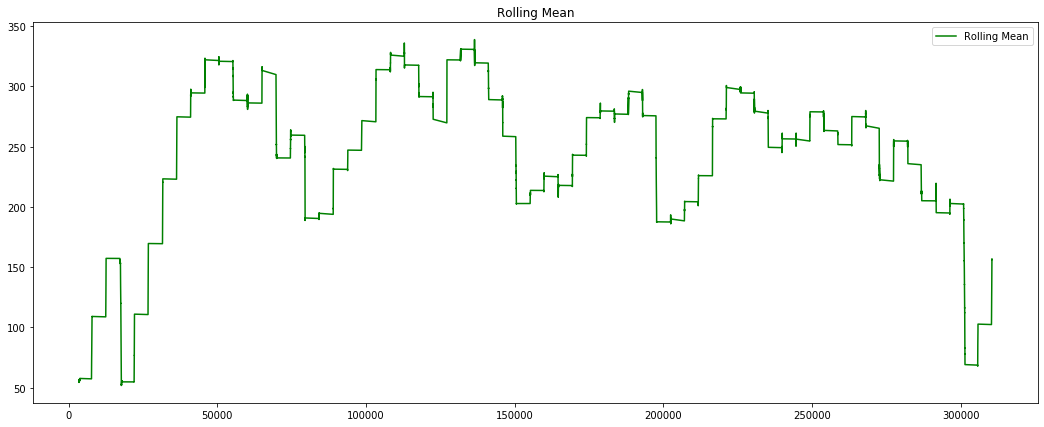

In [376]:
rolling_mean = df.pace.rolling(500).mean()
plt.figure(figsize=(18,7))
plt.plot(rolling_mean, color = 'green', label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.title('Rolling Mean')
plt.show()

### Check Variance
The variance should not be a function of time

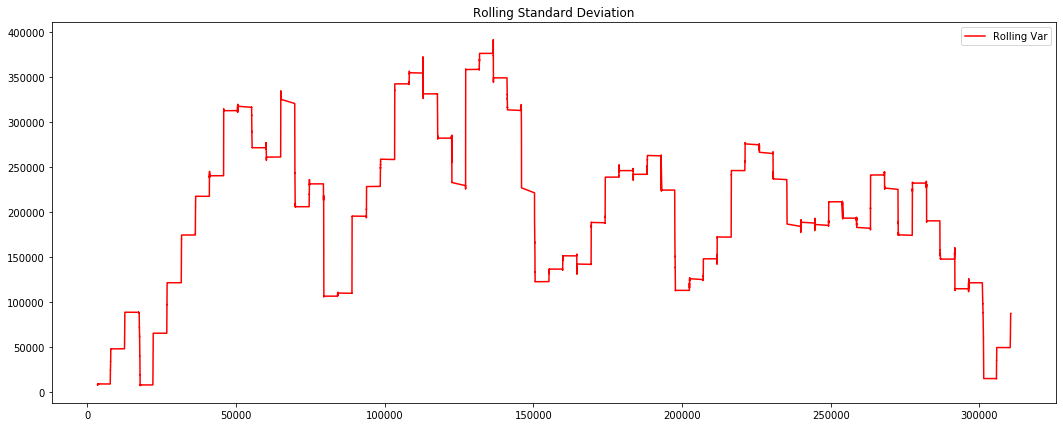

In [431]:
rolling_std = df.pace.rolling(500).std()**2
plt.figure(figsize=(18,7))
plt.plot(rolling_std, color = 'red', label = 'Rolling Var')
plt.legend(loc = 'best')
plt.title('Rolling Standard Deviation')
plt.show()

# Arima model


In [388]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import acf, pacf

**Order (ar, i, ma):**
   
    - ar (p) : autoregressive.
        The number of lag observations included in the model, also called the lag order.
    - i (d): integrated.
        The number of times that the raw observations are differenced, also called the degree of differencing.
    - ma (q): moving avarage.
        The size of the moving average window, also called the order of moving average.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

    
**Seasonal order (ar, i, ma, s):**

    - s : seasonal.
        After how many data points the behaiour repeats

If behaviours are full seasonal ar and ma are zero in the normal order.

## Understanding our data

In a linear regression model the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

### 1. Remove the trend
We remove the tredn through differencing.

In [305]:
df_notrend = df.diff()[1:]

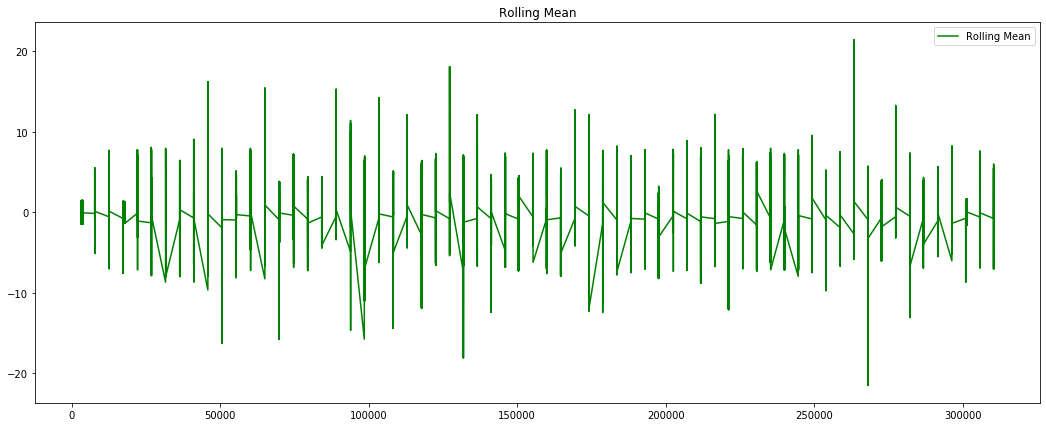

In [312]:
rolling_mean = df_notrend.pace.rolling(100).mean()
plt.figure(figsize=(18,7))
plt.plot(rolling_mean, color = 'green', label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.title('Rolling Mean')
plt.show()

First order differencing is enough to make the series stationary (mean around 0)

### 2. Seasonal behavior (lags)
It gives an indication on the order to be used.

#### ACF

/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<BarContainer object of 10 artists>

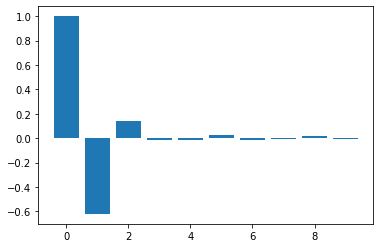

In [438]:
lags = acf(df_notrend.pace)
n_sessions = 10
plt.bar(range(n_sessions),lags[:n_sessions])

No significant lags

#### PACF 

<BarContainer object of 10 artists>

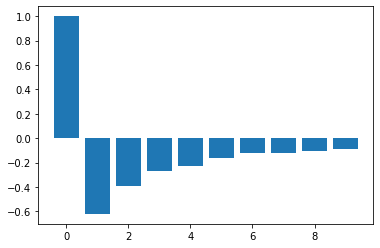

In [439]:
p_lags = pacf(df_notrend.pace)
plt.bar(range(n_sessions),p_lags[:n_sessions])

No significant lags

## Building the model

In [427]:
endog = df_notrend.pace
exog = df.drop('pace',axis='columns').drop('timestamp',axis='columns').to_numpy()

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [444]:
order=(0,1,2) 
seasonal_order = (0,1,0,0)

In [445]:
# model
model = ARIMA(endog=endog,exog=exog, order=order)
model_fit = model.fit()
print(model_fit.summary())

/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                             ARIMA Model Results                              
Dep. Variable:                 D.pace   No. Observations:                 9588
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -67437.579
Method:                       css-mle   S.D. of innovations            274.266
Date:                Sun, 04 Jul 2021   AIC                         134899.158
Time:                        11:19:06   BIC                         134985.177
Sample:                             1   HQIC                        134928.336
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0054        nan        nan        nan         nan         nan
x1               0.0174      0.001     18.466      0.000       0.016       0.019
x2              -0.0115      0.005     -2.09

/home/martina/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


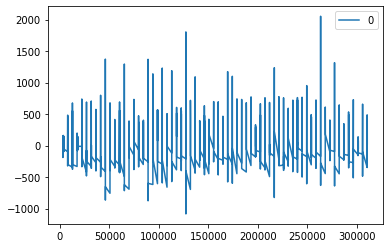

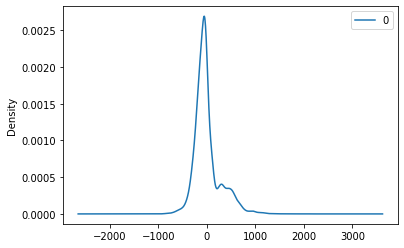

                 0
count  9588.000000
mean      1.009353
std     269.672529
min   -1085.099259
25%    -152.713547
50%     -51.486746
75%      74.138591
max    2053.372143


In [437]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# summary stats of residuals
print(residuals.describe())

## Improovements 

To avoid systematic bias due to the prediction in advance we may use rolling forecast residuals, meaning that if our test set is one training session we predict 10 minutes at a time